# Exploratory Analysis on COVID-19 Testing Data in the US 
Jaisal Friedman 
## Data Sources
1. [U.S. State by State Testing Data] (https://covidtracking.com/api)
2. [U.S. State by State Population Data 2019] (https://api.census.gov/data/2019/pep/population?get=POP&for=us:*)
3. [U.S. State Stay-at-Home Orders Dataes] (https://www.nytimes.com/interactive/2020/us/states-reopen-map-coronavirus.html)


In [0]:
!pip install -U plotly
!pip install linearmodels
!pip install stargazer 

     |████████████████████████████████| 11.5MB 3.3MB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1
     |████████████████████████████████| 1.5MB 3.4MB/s 


In [0]:
import pandas as pd 
import numpy as np 
import statsmodels.api as sm
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import seaborn as sns
from urllib.request import urlopen
import json
import math
import plotly
from google.colab import files
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm
from linearmodels import PanelOLS, PooledOLS, RandomEffects
from stargazer.stargazer import Stargazer
from scipy.optimize import curve_fit

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Import and Correct Data

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/jaisal1024/coronavirus-us-testing/master/data/cleaned/05-08_df_cleaned_state_pop.csv')
df["date"] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['fips'] = df['fips'].apply(lambda x: str(x) if x > 9 else "0" + str(x))
df['date_str'] = df['date'].apply(lambda x: dt.strftime(x, "%Y-%m-%d"))
df["pct_positiveIncrease"] = df["positiveIncrease"] / df["totalTestResultsIncrease"]

# Select Top 5 States

In [0]:
top_5_states = df.loc[df["date"] == dt.strptime('2020-05-02', '%Y-%m-%d')].sort_values(by = 'totalTestResults').tail(5)['state_abbr']
df_top5_select = df.loc[(df["state_abbr"].isin(top_5_states)) & (df["date"] >= dt.strptime('2020-03-15', '%Y-%m-%d')),].copy()

# Asymptotic Analysis 

In [0]:
fig = px.scatter(df_top5_select, x="totalTestResults", y="positive",
	               color="state_abbr",
                 hover_name="state_name", size_max=60,
                 title = "Total Tests by Total Positive Count Case for Top 5 Most Tested States")
fig.show()

In [0]:
fig = px.scatter(df.groupby('date').sum(), x="totalTestResults", y="positive",
                 title = "Total Tests by Total Positive Count Case for US")
fig.show()

In [0]:
def logistic_func(x, k, L, x0):
    return L/(1+ np.exp(-1 * k * (x-x0)))

def plot_lf(x, y, title, p0 = None, bounds = None): 
  plt.plot(x, y, 'b-', label='data')
  if p0 and bounds: 
    params, p_cov = curve_fit(logistic_func, x[10:], y[10:], p0 = p0, bounds = bounds)
  else: 
    params, p_cov = curve_fit(logistic_func, x, y)
  plt.plot(x, logistic_func(x, params[0], params[1], params[2]), 'g--', label='fit: k=%5.1E, L=%5.1E, x0=%5.1E' % tuple(params))
  plt.xlabel(x.name)
  plt.ylabel(y.name)
  plt.title(title)
  plt.legend()
  plt.show()
  return params

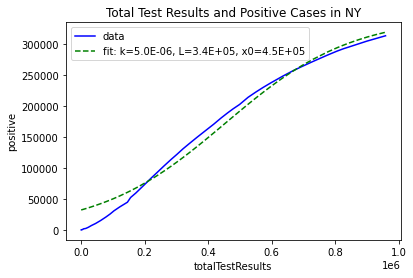

In [0]:
params_ny = plot_lf(df.query("state_abbr == 'NY'")["totalTestResults"], df.query("state_abbr == 'NY'")["positive"], "Total Test Results and Positive Cases in NY", p0=(4.8e-06, 500000, 500000), bounds=([0,300000, 0], [5e-06, 500000, 500000]))

In [0]:
df_ny_select = df.query("state_abbr == 'NY'").copy()
df_ny_select["positive_14_lag"] = df_ny_select["positive"].shift(14)
df_ny_select = df_ny_select.iloc[14:]

In [0]:
fig = px.scatter(df_ny_select, x="positive_14_lag", y="death", 
                 hover_name="state_name", hover_data = ['date_str'], size_max=60, 
                 title = "Case Counts and Deaths with a 14 Day Lag in NY")
fig.show()

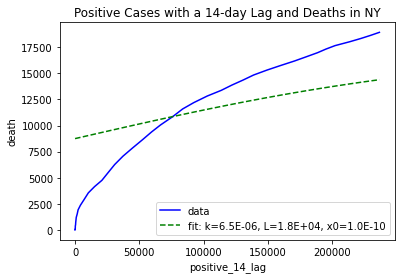

In [0]:
params_ny_death = plot_lf(df_ny_select["positive_14_lag"], df_ny_select["death"], "Positive Cases with a 14-day Lag and Deaths in NY", p0=(3e-06, 17500, 0), bounds=([0, 17500, 0], [1e-05, 50000, 500]))

In [0]:
print(params_ny)

[5.00000000e-06 3.44210922e+05 4.54451890e+05]


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning:

overflow encountered in exp



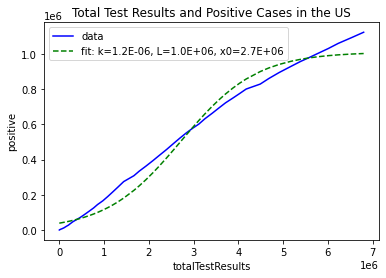

In [0]:
params_us = plot_lf(df.groupby('date').sum()["totalTestResults"], df.groupby('date').sum()["positive"], "Total Test Results and Positive Cases in the US")

In [0]:
params_ny

array([1.e-07, 3.e+05, 5.e+05])

# Export 

In [0]:
def export_df(df_, name): 
  df_.to_csv('{}_{}.csv'.format(dt.now().strftime('%m-%d'), name)) 
  files.download('{}_{}.csv'.format(dt.now().strftime('%m-%d'), name))

In [0]:
export_df(df_ny_select[["positive_14_lag", "death"]], "NY_lag_deaths")

In [0]:
export_df(df.query("state_abbr == 'NY'")[["totalTestResults", "positive"]], "NY_tests_positives")

In [0]:
export_df(df.query('days_since_100_cases == 0')[["state_abbr", "date"]].set_index("state_abbr").sort_values(by = 'date'), "states_100th_case_date")

# Testing over Time State-by-State Visualization

In [0]:
fig = px.choropleth( df.loc[df["date"] >= dt.strptime('2020-03-01', '%Y-%m-%d')].sort_values(by='date_str')[["state_abbr", "tests_per_1000", "state_name", "date_str"]], 
                           color='tests_per_1000',
                           locationmode = 'USA-states',
                           locations='state_abbr',
                           color_continuous_scale="thermal_r",
                           hover_name = 'state_name',
                           scope = 'usa',
                           animation_frame = 'date_str',
                           animation_group = 'date_str', 
                           labels={'tests_per_1000':'Tests Per 1000 People'}, 
                           title = "US State-By-State Tests per 1000 People")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [0]:
fig = px.choropleth( df.loc[df["date"] >= dt.strptime('2020-03-01', '%Y-%m-%d')].sort_values(by='date_str')[["state_abbr", "positiveIncrease", "state_name", "date_str"]], 
                           color='positiveIncrease',
                           locationmode = 'USA-states',
                           locations='state_abbr',
                           color_continuous_scale="thermal_r",
                           hover_name = 'state_name',
                           scope = 'usa',
                           animation_frame = 'date_str',
                           animation_group = 'date_str', 
                           title = "US State-By-State Tests Daily Positive Increase")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# Auto and Cross-Correlation 

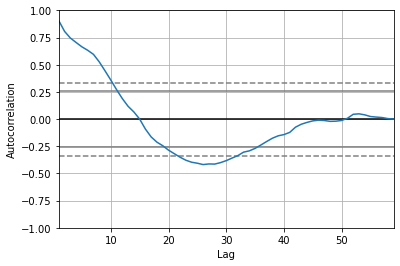

In [0]:
autocorrelation_plot(df.query("state_abbr == 'NY'")["positiveIncrease"].dropna())

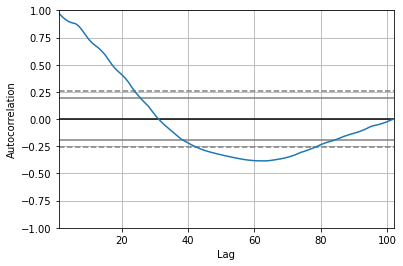

In [0]:
autocorrelation_plot(df.groupby(by='date').sum()["positiveIncrease"])

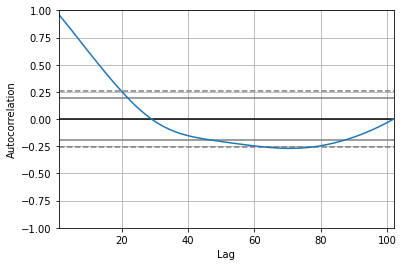

In [0]:
autocorrelation_plot(df.groupby(by='date').sum()[""])

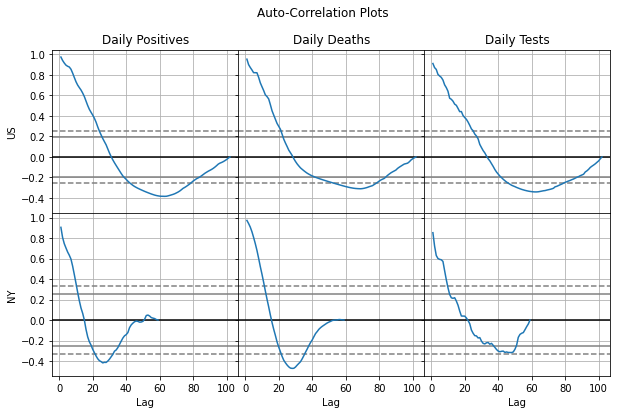

In [0]:
fig, axs = plt.subplots(2, 3, sharey= True, sharex=True,  figsize=(10, 6), gridspec_kw={'hspace': 0, 'wspace': 0})
fig.suptitle('Auto-Correlation Plots')
autocorrelation_plot(df.groupby(by='date').sum()["positiveIncrease"], ax = axs[0, 0])
axs[0, 0].set_title('Daily Positives')
autocorrelation_plot(df.query("state_abbr == 'NY'")["positiveIncrease"].dropna(), ax = axs[1, 0])
autocorrelation_plot(df.groupby(by='date').sum()["deathIncrease"], ax = axs[0, 1])
axs[0, 1].set_title('Daily Deaths')
autocorrelation_plot(df.query("state_abbr == 'NY'")["deathIncrease"].dropna(), ax = axs[1, 1])
autocorrelation_plot(df.groupby(by='date').sum()["totalTestResultsIncrease"], ax = axs[0, 2])
axs[0, 2].set_title('Daily Tests')
autocorrelation_plot(df.query("state_abbr == 'NY'")["totalTestResultsIncrease"].dropna(), ax = axs[1, 2])

for i, ax in enumerate(axs.flat):
    if i == 0: 
      ax.set(ylabel="US")
    elif i == 3: 
      ax.set(ylabel="NY")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# Percent Daily Positive of Tests

In [0]:
fig = px.scatter(df_top5_select, x= "days_since_100_cases", y="pct_positiveIncrease", 
                 color = "state_abbr", trendline = "ols", 
                 hover_name="state_name", hover_data = ["date_str"], size_max=60, 
                 title = "Percent Positive Increase and Days Since 100th Case for Top 5 States")
fig.show()

In [0]:
fig = px.scatter(df_top5_select.groupby(by = 'date').mean(), x=df_top5_select.groupby(by = 'date').mean().index, y="pct_positiveIncrease", 
                 title = "Percent Positive Increase and Date for US")
fig.show()